In [1]:
# Code link: https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

In [2]:
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

864550912/864538487 [==============================] - 22s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736570880/5736557430 [==============================] - 143s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528649728/5528640507 [==============================] - 196s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [2]:
# preparing data
# generate CSV metadata file to read img paths and labels from it
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [4]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [5]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape: (299, 299, 3)
Label: 0


In [6]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

In [7]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

AlreadyExistsError: There appears to be a concurrent caching iterator running - cache lockfile already exists ('valid-cached-data_0.lockfile'). If you are sure no other running TF computations are using this cache prefix, delete the lockfile and re-initialize the iterator. Lockfile contents: Created at: 1637086601 [Op:IteratorGetNext]

In [8]:
# building the model
# InceptionV3 model & pre-trained weights
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=100,
                callbacks=[tensorboard, modelcheckpoint])

# Save the entire model as a SavedModel.
m.save('my_model.h5')

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8110

AlreadyExistsError:  There appears to be a concurrent caching iterator running - cache lockfile already exists ('valid-cached-data_0.lockfile'). If you are sure no other running TF computations are using this cache prefix, delete the lockfile and re-initialize the iterator. Lockfile contents: Created at: 1637086601
	 [[node IteratorGetNext
 (defined at /Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py:1355)
]] [Op:__inference_test_function_26354]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext:
In[0] iterator (defined at /Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py:1537)

Operation defined at: (most recent call last)
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
>>>     user_expressions, allow_stdin,
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2895, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3166, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-9-66db7951e5ee>", line 9, in <module>
>>>     callbacks=[tensorboard, modelcheckpoint])
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py", line 1263, in fit
>>>     _use_cached_eval_dataset=True)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py", line 1537, in evaluate
>>>     tmp_logs = self.test_function(iterator)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py", line 1366, in test_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/sudirjain/opt/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/training.py", line 1355, in step_function
>>>     data = next(iterator)
>>> 

In [ ]:
# evaluation
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [ ]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [12]:
# load the weights with the least loss
#m.load_weights("benign-vs-malignant_64_rmsprop_0.406.h5")

#Load model 
m = tf.keras.models.load_model('my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [13]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...


NameError: ignored

In [ ]:
#Make predictions 
y_pred = m.predict(X_test)

Prediction: Malignant
Original Label: Benign


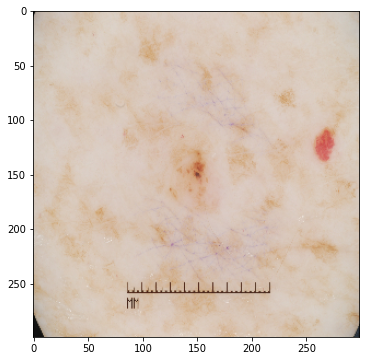

In [ ]:
# generate random integer values
from random import randint
# seed random number generator
# generate some integers
value = randint(0, len(X_test))
y_pred_1 = y_pred[value]

threshold = 0.23 

if y_pred_1 >= threshold:
  print ('Prediction: Malignant')
else:
  print ('Prediction: Benign')

if y_test[value] ==1:
    print ('Original Label: Malignant')
else:
    print ('Original Label: Benign')

plt.figure(figsize=(6,6))
plt.imshow(np.array(X_test[value]))